<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/contest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
# 1. 데이터 로드 및 전처리 함수 (여러 경로를 받을 수 있도록 수정)
def load_data(base_paths):
    classes = ['normal', 'inner_fault', 'outer_fault', 'roller_fault']
    data = []
    labels = []
    for base_path in base_paths:
        for label, class_name in enumerate(classes):
            folder_path = os.path.join(base_path, class_name)
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                mat_data = scipy.io.loadmat(file_path)
                signal = mat_data['signal'].flatten()  # 1차원 배열로 변환

                # 신호를 세그먼트로 분할 (각 세그먼트 길이: 1024 샘플)
                segment_length = 1024
                num_segments = len(signal) // segment_length
                for i in range(num_segments):
                    segment = signal[i * segment_length : (i + 1) * segment_length]
                    data.append(segment)
                    labels.append(label)

    # Numpy 배열로 변환
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [4]:
# 두 개의 데이터 폴더 경로 설정
base_paths = ['/content/drive/MyDrive/bearing1', '/content/drive/MyDrive/bearing2']
data, labels = load_data(base_paths)

# 데이터 정규화 및 레이블 원-핫 인코딩
data = data / np.max(np.abs(data))  # 정규화
labels = to_categorical(labels, num_classes=4)  # 원-핫 인코딩

# 훈련 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [5]:
# 2. 1D CNN 모델 구성
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(1024, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 3. 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
860/860 [==============================] - 12s 12ms/step - loss: 0.5251 - accuracy: 0.7442 - val_loss: 0.2939 - val_accuracy: 0.8775
Epoch 2/20
860/860 [==============================] - 10s 12ms/step - loss: 0.3354 - accuracy: 0.8462 - val_loss: 0.2487 - val_accuracy: 0.8774
Epoch 3/20
860/860 [==============================] - 10s 12ms/step - loss: 0.2649 - accuracy: 0.8849 - val_loss: 0.1855 - val_accuracy: 0.9088
Epoch 4/20
860/860 [==============================] - 10s 12ms/step - loss: 0.2265 - accuracy: 0.9029 - val_loss: 0.1928 - val_accuracy: 0.9257
Epoch 5/20
860/860 [==============================] - 10s 12ms/step - loss: 0.2037 - accuracy: 0.9161 - val_loss: 0.1366 - val_accuracy: 0.9488
Epoch 6/20
860/860 [==============================] - 10s 12ms/step - loss: 0.1942 - accuracy: 0.9187 - val_loss: 0.1443 - val_accuracy: 0.9335
Epoch 7/20
860/860 [==============================] - 10s 12ms/step - loss: 0.1745 - accuracy: 0.9301 - val_loss: 0.1277 - val_accuracy:

In [8]:
# 4. 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

269/269 [==============================] - 1s 4ms/step - loss: 0.0082 - accuracy: 0.9980
Test Accuracy: 0.9980


In [9]:
# 모델 저장
model.save('bearing_fault_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# 6. 혼동 행렬 및 분류 보고서 생성
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측한 클래스
y_true = np.argmax(y_test, axis=1)          # 실제 클래스

269/269 [==============================] - 1s 4ms/step


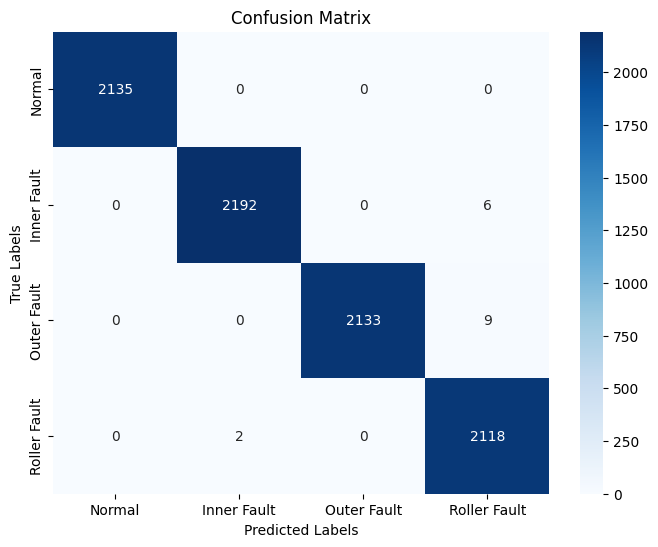

In [11]:
# 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'],
            yticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# 분류 보고서 출력
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2135
 Inner Fault       1.00      1.00      1.00      2198
 Outer Fault       1.00      1.00      1.00      2142
Roller Fault       0.99      1.00      1.00      2120

    accuracy                           1.00      8595
   macro avg       1.00      1.00      1.00      8595
weighted avg       1.00      1.00      1.00      8595



269/269 [==============================] - 1s 5ms/step


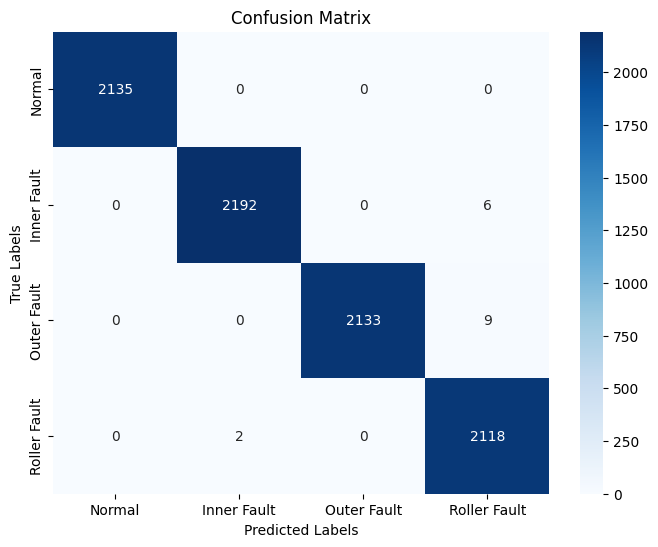

In [13]:
# 테스트 데이터에 대한 예측 생성
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측한 클래스
y_true = np.argmax(y_test, axis=1)          # 실제 클래스

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'],
            yticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# 분류 보고서 출력 (정밀도, 재현율, F1 스코어 포함)
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2135
 Inner Fault       1.00      1.00      1.00      2198
 Outer Fault       1.00      1.00      1.00      2142
Roller Fault       0.99      1.00      1.00      2120

    accuracy                           1.00      8595
   macro avg       1.00      1.00      1.00      8595
weighted avg       1.00      1.00      1.00      8595



In [15]:
# 전체 F1 스코어 계산
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

Macro F1 Score: 0.9980
Weighted F1 Score: 0.9980
